## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [67]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from plotnine import *
import matplotlib.pyplot as plt

In [77]:
ha = pd.read_csv('https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1')
X = ha[["age","chol"]]
y = ha["diagnosis"]

y = y.map({'Disease': 1, 'No Disease': 0})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

ha.head()

ct = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), ['age', 'chol'])
]).set_output(transform="pandas")

In [78]:
ha['diagnosis'] = ha['diagnosis'].map({'Disease': 0, 'No Disease': 1})

log_pipeline = Pipeline([
    ("preprocessing", ct),
    ("logistic_regression", LogisticRegression(penalty = "l2", random_state = 1))
])

In [79]:
log_reg_fitted = log_pipeline.fit(X, y)

log_reg = log_pipeline.named_steps["logistic_regression"]

intercept_log = log_reg.intercept_[0]
coef_age_log, coef_chol_log = log_reg.coef_[0] #extract coefficients

In [80]:
age = 55
log_odds50 = 0
chol_50 = (log_odds50 - intercept_log - coef_age_log * age) / coef_chol_log

log_odds90 = np.log(0.9 / (1 - 0.9)) #for 90%
chol_90 = (log_odds90 - intercept_log - coef_age_log * age) / coef_chol_log

print("Chol 50%: ", chol_50)
print("Chol 90%: ", chol_90)

Chol 50%:  -242.14639682791764
Chol 90%:  -265.04001308972846


## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [81]:
#lda
pipeline_lda = Pipeline(steps=[
    ("preprocessing", ct),
    ("lda", LinearDiscriminantAnalysis())
])

pipeline_lda.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['age', 'chol'])])),
                ('lda', LinearDiscriminantAnalysis())])

In [82]:
lda_model = pipeline_lda.named_steps['lda'] #coeffs
coefficients = lda_model.coef_[0]
intercept = lda_model.intercept_[0]

logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

-248.86402351754188


## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [83]:
svc_pipeline = Pipeline(
    [("preprocessing", ct),
    ("svc", SVC(kernel="linear"))]
)

svc_pipeline.fit(X, y)

#tuning
params = {
    'svc__C': [0.001, 0.01, 0.1, 1, 10],
}
grid_search = GridSearchCV(svc_pipeline, params, cv = 5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'chol'])])),
                                       ('svc', SVC(kernel='linear'))]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10]},
             scoring='neg_mean_squared_error')

In [84]:
svc_model = grid_search.best_estimator_.named_steps['svc'] #coeffs
coefficients = svc_model.coef_[0]
intercept = svc_model.intercept_[0]

logit = np.log(0.5/(1 - 0.5))
print((logit - intercept - coefficients[0] * 55) / coefficients[1])

-168.68767720751316


## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

In [85]:
import numpy as np
import matplotlib.pyplot as plt


# Generate grid for decision boundary
x_min, x_max = X['age'].min() - 1, X['age'].max() + 1
y_min, y_max = X['chol'].min() - 1, X['chol'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert grid to DataFrame with appropriate column names
grid_df = pd.DataFrame(grid, columns=['age', 'chol'])

# Predict probabilities for each model
Z1 = log_pipeline.predict(grid_df).reshape(xx.shape)
Z2 = pipeline_lda.predict(grid_df).reshape(xx.shape)
Z3 = svc_pipeline.predict(grid_df).reshape(xx.shape)



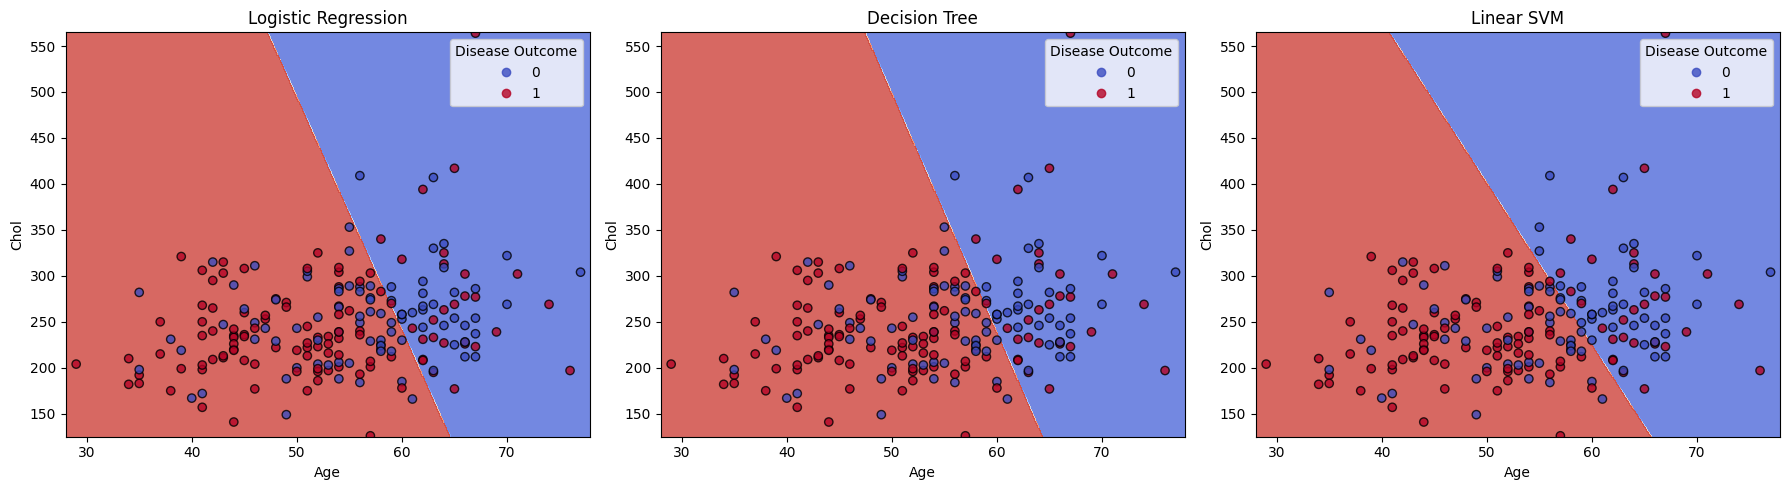

In [88]:
# Plot decision boundaries and scatterplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = [("Logistic Regression", Z1), ("Decision Tree", Z2), ("Linear SVM", Z3)]
for i, (title, Z) in enumerate(models):
    ax = axes[i]
    ax.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    scatter = ax.scatter(
        X['age'], X['chol'], c=y, edgecolor='k', cmap='coolwarm', alpha=0.8
    )
    ax.set_title(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Chol')
    ax.legend(*scatter.legend_elements(), title="Disease Outcome")

plt.tight_layout()
plt.show()